In [625]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox

### Загрузка данных

In [626]:
beer_sales_data = pd.read_parquet('Data/beer_sales_data.parquet')
cig_sales_data = pd.read_parquet('Data/cig_sales_data.parquet')
ana_sales_data = pd.read_parquet('Data/ana_sales_data.parquet')

# Удаляем `not important` колонки из **upc** таблиц
upc_cols2drop = ['com_code', 'case']
beer_upc_data = pd.read_parquet('Data/beer_upc.parquet').drop(columns=upc_cols2drop)
cig_upc_data = pd.read_parquet('Data/cig_upc.parquet').drop(columns=upc_cols2drop)
ana_upc_data = pd.read_parquet('Data/ana_upc.parquet').drop(columns=upc_cols2drop)

demographic_data = pd.read_parquet('Data/demographic_data.parquet')

weeks_data = pd.read_csv('Data/weeks_data.csv')

## EDA beer_sales

In [627]:
beer_sales_data.head()

,store,upc,week,move,qty,price,sale
0,2,294,298,11,1,2.62,None
1,2,294,299,9,1,2.51,None
2,2,294,300,6,1,2.49,None
3,2,294,301,5,1,2.99,None
4,2,294,302,1,1,2.49,None


### Работа с типами данных

In [628]:
beer_sales_data.dtypes

store      int64
upc        int64
week       int64
move       int64
qty        int64
price    float64
sale      object
dtype: object

Колонка **store** состоит из id магазинов, поэтому её можно считать типа **object**.  
Аналогичное имеет смысл сделать с **upc** и **week**

In [629]:
beer_sales_data = beer_sales_data.astype({'store': 'object', 'upc': 'object', 'week': 'object'})

### Работа с пропусками

In [630]:
beer_sales_data.isna().sum()

store          0
upc            0
week           0
move           0
qty            0
price          0
sale     3420284
dtype: int64

Единственные `None` значения присутствуют в столбце **sale**.  
В силу того, что **sale** равный `None` означает продажу без скидки, то заменим на `N`

In [631]:
beer_sales_data.fillna({'sale': 'N'}, inplace=True)

### Работа с числовыми признаками

In [632]:
beer_sales_data.describe()

,move,qty,price
count,3.967720e+06,3.967720e+06,3.967720e+06
mean,3.383864e+00,1.000011e+00,2.819041e+00
std,8.877261e+00,3.330071e-03,3.422010e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+00,0.000000e+00
75%,3.000000e+00,1.000000e+00,4.990000e+00
max,7.690000e+02,2.000000e+00,2.964000e+01


Посмотрим коэффициенты вариации для соответствующих колонок

In [633]:
beer_sales_std_desc = beer_sales_data.select_dtypes('number').apply(
    lambda x: (x.std(), x.std() / x.mean() * 100), axis=0)
beer_sales_std_desc.index = ['std', 'cv']
beer_sales_std_desc

,move,qty,price
std,8.877261,0.003330,3.422010
cv,262.340936,0.333003,121.389136


In [634]:
del beer_sales_std_desc

Можно заметить, что коэффициент вариации у всех колонок кроме **qty** > 30%.  
Поэтому проанализируем данный столбец.

In [635]:
beer_sales_data['qty'].value_counts()

qty
1    3967676
2         44
Name: count, dtype: int64

В силу того, что **qty** имеет только два уникальных значения, и одно из них есть только в 44 экземплярах среди почти 4 миллионов, можно убрать столбец в силу его квазиконстантности.

In [636]:
beer_sales_data.drop(columns=['qty'], inplace=True)

move        Axes(0.125,0.11;0.352273x0.77)
price    Axes(0.547727,0.11;0.352273x0.77)
dtype: object

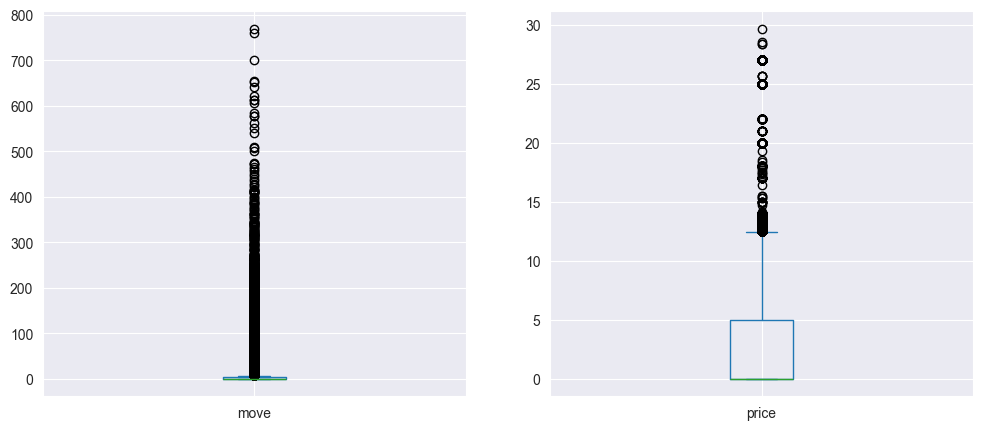

In [637]:
beer_sales_data.plot(kind='box',
                     subplots=True,
                     figsize=(12, 5),
                     sharex=False,
                     sharey=False)

Посмотрим на то, какой процент от всех занимают точки, лежащие за верхней границей.

In [638]:
beer_sales_move_Q1 = beer_sales_data['move'].quantile(0.25)
beer_sales_move_Q3 = beer_sales_data['move'].quantile(0.75)
beer_sales_move_IQR = beer_sales_move_Q3 - beer_sales_move_Q1
beer_sales_move_upper_whisker = beer_sales_move_Q3 + 1.5 * beer_sales_move_IQR
beer_sales_move_percent = ((beer_sales_data['move'] > beer_sales_move_upper_whisker).sum()
                           / beer_sales_data.shape[0] * 100)

beer_sales_price_Q1 = beer_sales_data['price'].quantile(0.25)
beer_sales_price_Q3 = beer_sales_data['price'].quantile(0.75)
beer_sales_price_IQR = beer_sales_price_Q3 - beer_sales_price_Q1
beer_sales_price_upper_whisker = beer_sales_price_Q3 + 1.5 * beer_sales_price_IQR
beer_sales_price_percent = ((beer_sales_data['price'] > beer_sales_price_upper_whisker).sum()
                            / beer_sales_data.shape[0] * 100)

print(f'move - {beer_sales_move_percent}', f'price - {beer_sales_price_percent}', sep='\n')

move - 12.122352383736755
price - 0.6224481566239554


In [639]:
del beer_sales_move_Q1
del beer_sales_move_Q3
del beer_sales_move_IQR
del beer_sales_move_upper_whisker
del beer_sales_move_percent

del beer_sales_price_Q1
del beer_sales_price_Q3
del beer_sales_price_IQR
del beer_sales_price_upper_whisker
del beer_sales_price_percent

В силу незначительного процента у **price** оставим их, а у **move** уберём те, что выше 99.5 квантиля.

In [640]:
# beer_sales_data = beer_sales_data[beer_sales_data['move'] <= beer_sales_data['move'].quantile(0.995)]

# удалять или не удалять???

move        Axes(0.125,0.11;0.352273x0.77)
price    Axes(0.547727,0.11;0.352273x0.77)
dtype: object

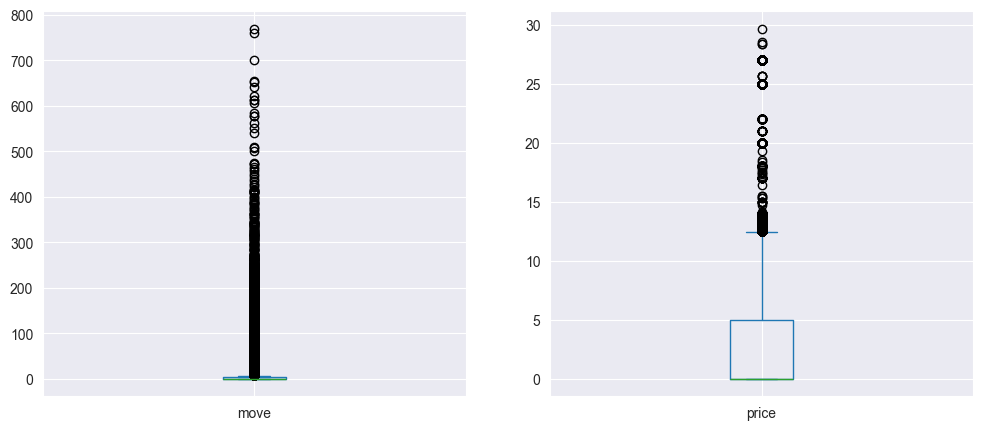

In [641]:
beer_sales_data.plot(kind='box',
                     subplots=True,
                     figsize=(12, 5),
                     sharex=False,
                     sharey=False)

Добавим признак **event**, говорящий о наличии праздников на неделе.

In [642]:
beer_sales_data = beer_sales_data.join(weeks_data[['week', 'event']].set_index('week'), how='inner', on='week')

In [643]:
beer_sales_data['event'].value_counts()

event
Labor Day         87235
4th of July       83750
Easter            76245
Halloween         74951
New-Year          73234
Christmas         73088
Thanksgiving      72506
Memorial Day      69669
Presidents Day    59007
Name: count, dtype: int64

Посмотрим на распределение количества продаж по неделям

In [958]:
beer_sales_amount_by_week = beer_sales_data.groupby('week').agg(
    sales_amount=pd.NamedAgg('move', 'sum')).reset_index().sort_values(by='sales_amount')
beer_sales_amount_by_week.head()

,week,sales_amount
232,330,9167
236,334,10321
285,383,10640
227,325,10683
239,337,11236


<Axes: title={'center': 'beer_sales_amount_by_week'}, xlabel='week', ylabel='sales_amount'>

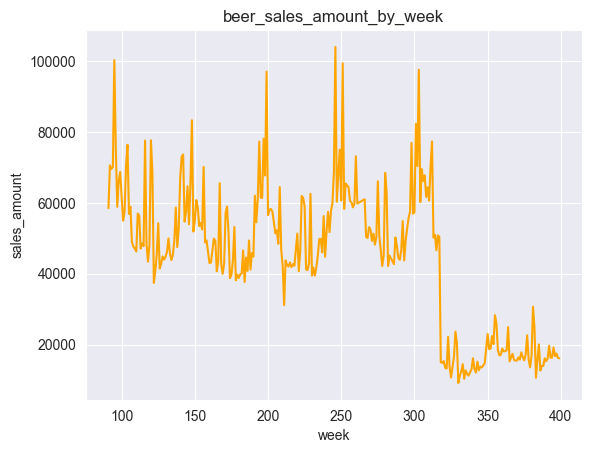

In [959]:
plt.title('beer_sales_amount_by_week')
sns.lineplot(x=beer_sales_amount_by_week['week'],
             y=beer_sales_amount_by_week['sales_amount'],
             c='orange')

In [960]:
beer_sales_amount_event_weeks = (
    weeks_data[(~weeks_data['event'].isna()) & (weeks_data['week'] >= beer_sales_amount_by_week['week'].min()) &
               (weeks_data['week'] <= beer_sales_amount_by_week['week'].max())]
    .groupby('event')['week']
    .apply(list)
    .to_dict()
)
beer_sales_amount_event_weeks

{'4th of July': [95, 147, 199, 251, 303, 356],
 'Christmas': [119, 172, 224, 276, 328, 380],
 'Easter': [133, 185, 238, 289, 341, 393],
 'Halloween': [112, 164, 216, 268, 320, 372],
 'Labor Day': [103, 156, 208, 260, 312, 364],
 'Memorial Day': [141, 194, 246, 298, 350],
 'New-Year': [120, 173, 225, 277, 329, 381],
 'Presidents Day': [128, 180, 232, 284, 336, 389],
 'Thanksgiving': [116, 168, 220, 272, 324, 377]}

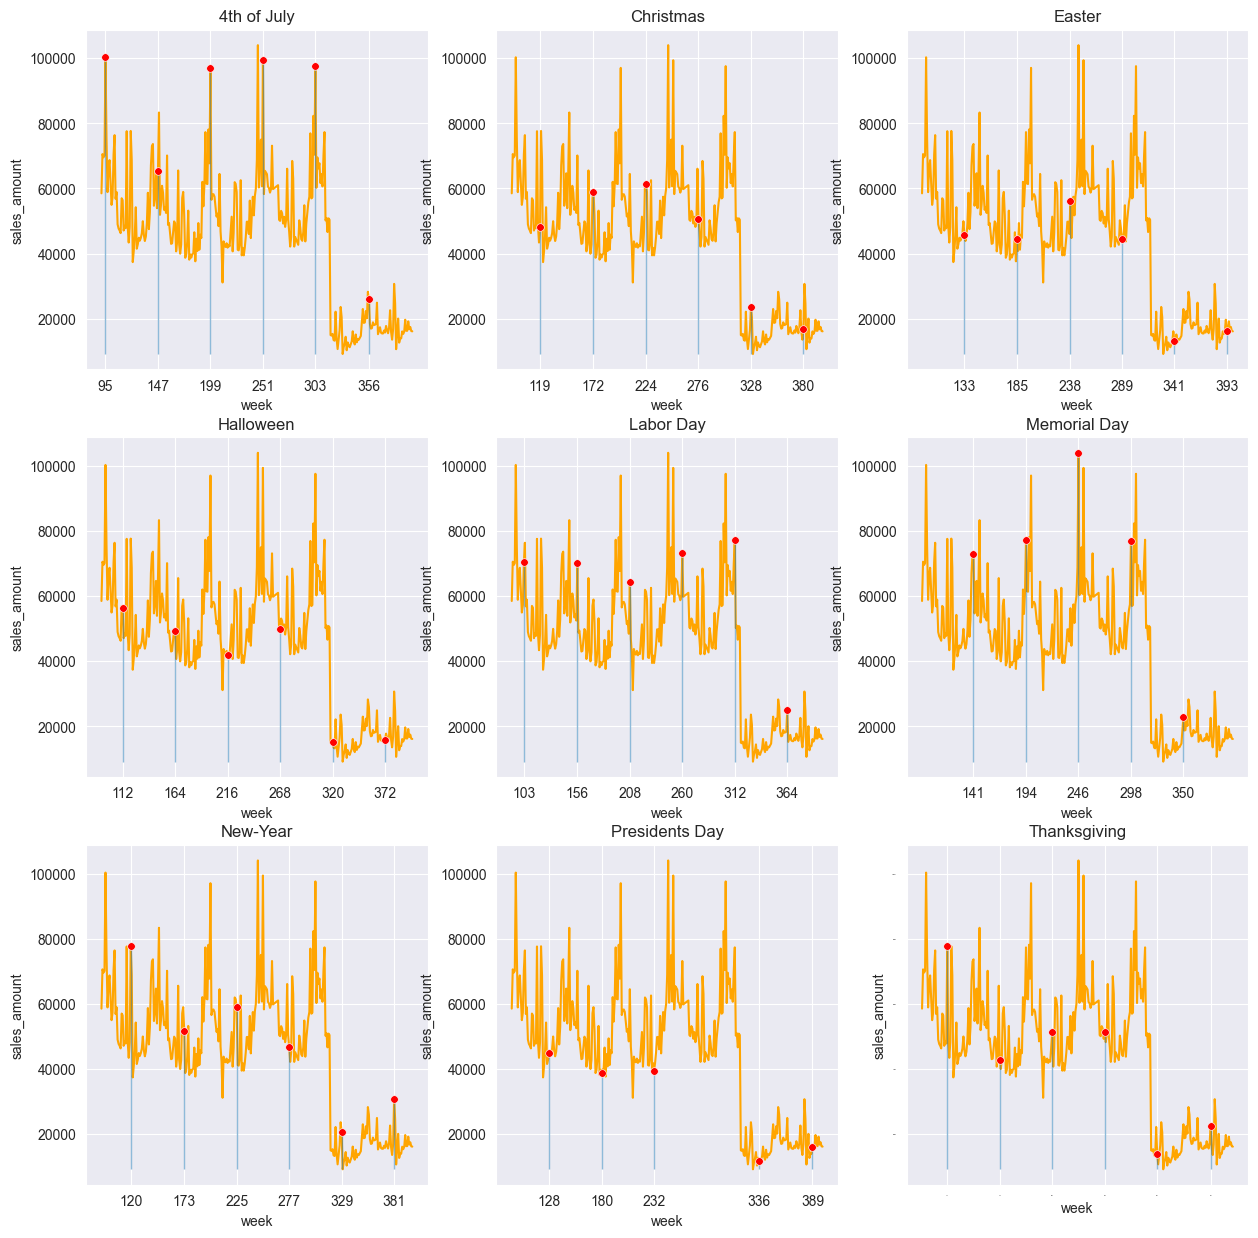

In [962]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

plt.xticks(fontsize=1)
plt.yticks(fontsize=1)

for i, (event, weeks) in enumerate(beer_sales_amount_event_weeks.items()):
    ax[i].set_title(event)

    sns.lineplot(ax=ax[i],
                 x=beer_sales_amount_by_week['week'],
                 y=beer_sales_amount_by_week['sales_amount'],
                 c='orange',
                 zorder=1)

    s = beer_sales_amount_by_week[beer_sales_amount_by_week['week'].isin(weeks)][['sales_amount', 'week']]

    ax[i].vlines(x=s['week'],
                 ymin=beer_sales_amount_by_week['sales_amount'].min(),
                 ymax=s['sales_amount'], zorder=2, linewidth=1, alpha=0.5)

    sns.scatterplot(ax=ax[i],
                    x=s['week'],
                    y=s['sales_amount'],
                    color='red',
                    zorder=3,
                    s=30)

    ax[i].set_xticks(s.week)

In [963]:
del s
del beer_sales_amount_by_week
del beer_sales_amount_event_weeks

Из графиков видно, что в большинство праздников люди покупают пиво больше, чем обычно.  
Хотя есть праздники, в которые количество продаж падает.

Посмотрим на распределение суммы продаж по неделям

In [655]:
beer_sales_revenue = beer_sales_data.copy()
beer_sales_revenue['revenue'] = (beer_sales_revenue['move'] * beer_sales_revenue['price'])

beer_sales_revenue_by_week = beer_sales_revenue.groupby('week').agg(
    revenue=pd.NamedAgg('revenue', 'sum')).reset_index()
beer_sales_revenue_by_week.head()

,week,revenue
0,91,326527.45
1,92,373810.95
2,93,360063.02
3,94,397556.36
4,95,555812.86


<Axes: title={'center': 'beer_sales_revenue_by_week'}, xlabel='week', ylabel='revenue'>

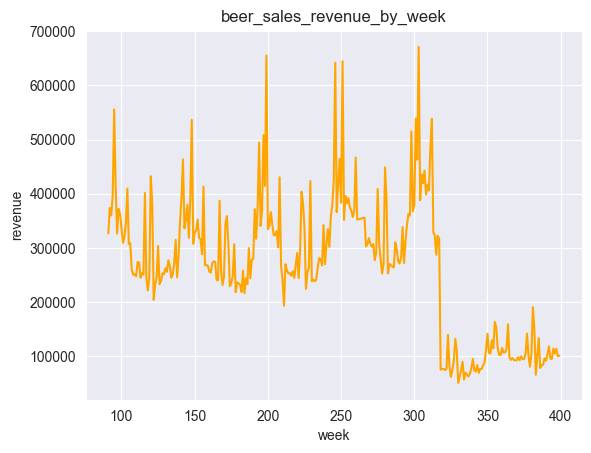

In [656]:
plt.title('beer_sales_revenue_by_week')
sns.lineplot(x=beer_sales_revenue_by_week['week'],
             y=beer_sales_revenue_by_week['revenue'],
             c='orange',
             zorder=1)

In [661]:
beer_sales_revenue_event_weeks = (
    weeks_data[(~weeks_data['event'].isna()) & (weeks_data['week'] >= beer_sales_revenue_by_week['week'].min()) &
               (weeks_data['week'] <= beer_sales_revenue_by_week['week'].max())]
    .groupby('event')['week']
    .apply(list)
    .to_dict()
)
beer_sales_revenue_event_weeks

{'4th of July': [95, 147, 199, 251, 303, 356],
 'Christmas': [119, 172, 224, 276, 328, 380],
 'Easter': [133, 185, 238, 289, 341, 393],
 'Halloween': [112, 164, 216, 268, 320, 372],
 'Labor Day': [103, 156, 208, 260, 312, 364],
 'Memorial Day': [141, 194, 246, 298, 350],
 'New-Year': [120, 173, 225, 277, 329, 381],
 'Presidents Day': [128, 180, 232, 284, 336, 389],
 'Thanksgiving': [116, 168, 220, 272, 324, 377]}

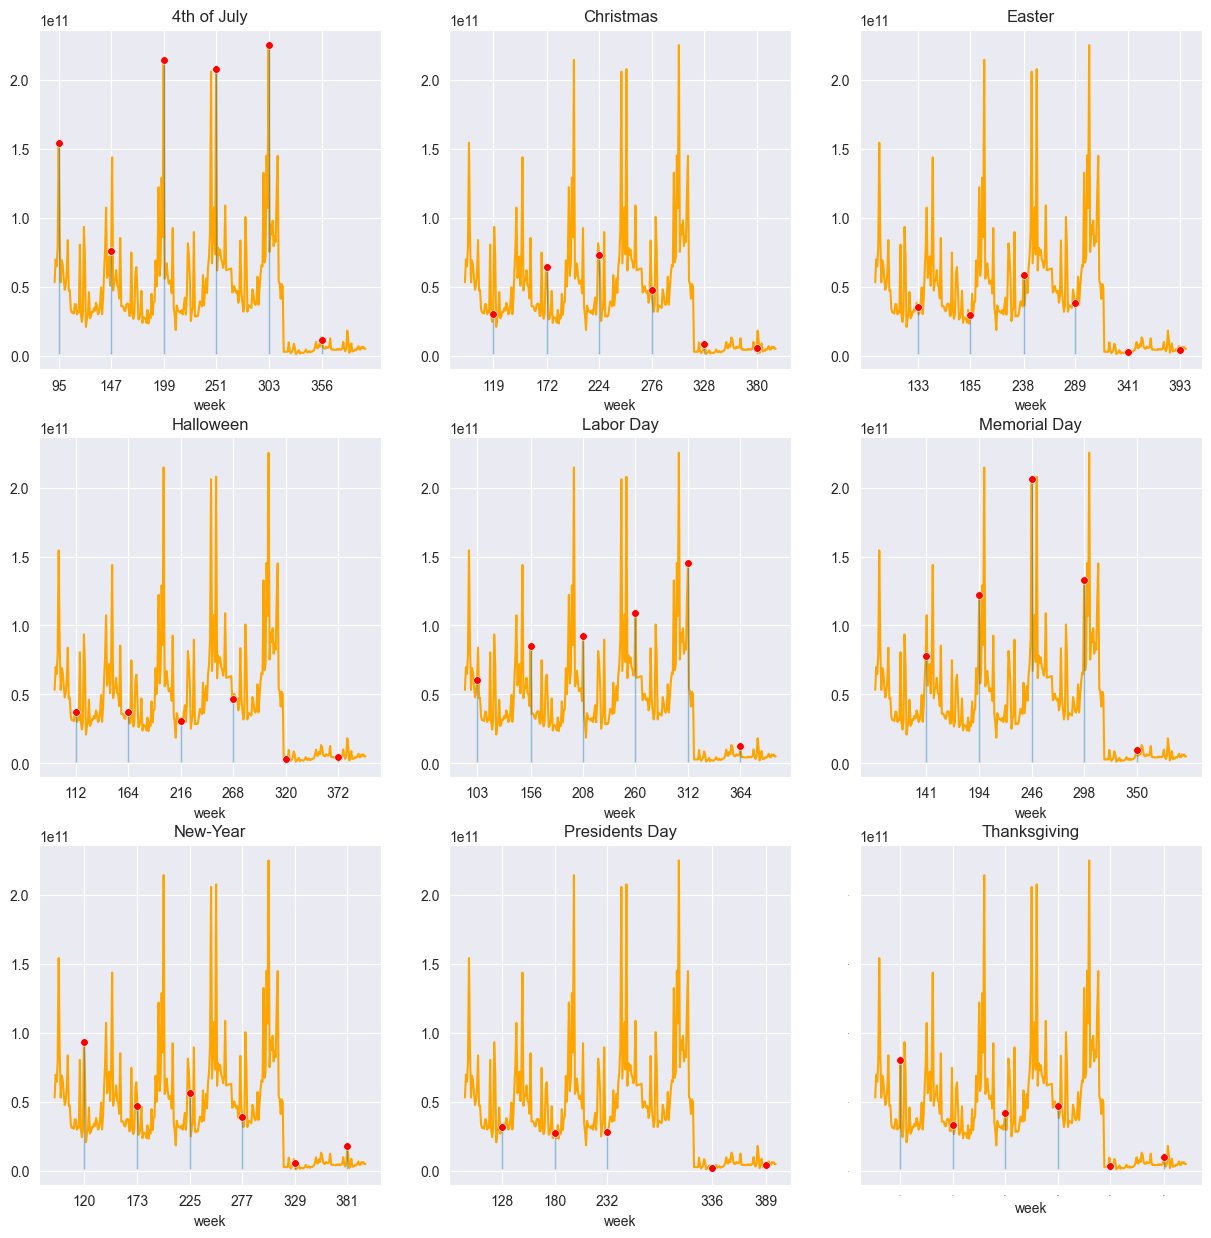

In [662]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

plt.xticks(fontsize=1)
plt.yticks(fontsize=1)

for i, (event, weeks) in enumerate(beer_sales_revenue_event_weeks.items()):
    ax[i].set_title(event)

    sns.lineplot(ax=ax[i],
                 x=beer_sales_revenue_by_week['week'],
                 y=boxcox(beer_sales_revenue_by_week['revenue'], lmbda=2),
                 c='orange',
                 zorder=1)

    s = beer_sales_revenue_by_week[beer_sales_revenue_by_week['week'].isin(weeks)][
        ['revenue', 'week']]

    ax[i].vlines(x=s['week'],
                 ymin=boxcox(beer_sales_revenue_by_week['revenue'], lmbda=2).min(),
                 ymax=boxcox(s['revenue'], lmbda=2), zorder=2, linewidth=1, alpha=0.5)

    sns.scatterplot(ax=ax[i],
                    x=s['week'],
                    y=boxcox(s['revenue'], lmbda=2),
                    color='red',
                    zorder=3,
                    s=30)

    ax[i].set_xticks(s.week)

Тут ситуация похожая на то, что было выше.

In [663]:
del s
del beer_sales_revenue_by_week
del beer_sales_revenue_event_weeks

В силу того, что не каждый праздник увеличивает продажи (некоторые и уменьшают), добавим данные о праздниках, используя ohe

In [664]:
beer_sales_data = pd.concat([beer_sales_data.drop(columns=['event']),
                             pd.get_dummies(beer_sales_data['event'], drop_first=False, dummy_na=False)], axis=1)
beer_sales_data.head()

,store,upc,week,move,price,sale,4th of July,Christmas,Easter,Halloween,Labor Day,Memorial Day,New-Year,Presidents Day,Thanksgiving
0,2,294,298,11,2.62,N,False,False,False,False,False,True,False,False,False
1,2,294,299,9,2.51,N,False,False,False,False,False,False,False,False,False
2,2,294,300,6,2.49,N,False,False,False,False,False,False,False,False,False
3,2,294,301,5,2.99,N,False,False,False,False,False,False,False,False,False
4,2,294,302,1,2.49,N,False,False,False,False,False,False,False,False,False


Также воспользуемся ohe для столбца sale

In [665]:
beer_sales_data_ohe = pd.concat([beer_sales_data.drop(columns=['sale']),
                                 pd.get_dummies(beer_sales_data['sale'], drop_first=True)], axis=1)
beer_sales_data_ohe.head()

,store,upc,week,move,price,4th of July,Christmas,Easter,Halloween,Labor Day,Memorial Day,New-Year,Presidents Day,Thanksgiving,C,N,S
0,2,294,298,11,2.62,False,False,False,False,False,True,False,False,False,False,True,False
1,2,294,299,9,2.51,False,False,False,False,False,False,False,False,False,False,True,False
2,2,294,300,6,2.49,False,False,False,False,False,False,False,False,False,False,True,False
3,2,294,301,5,2.99,False,False,False,False,False,False,False,False,False,False,True,False
4,2,294,302,1,2.49,False,False,False,False,False,False,False,False,False,False,True,False


Посмотрим на корреляции признаков

price         N              -0.369414
move          N              -0.353168
              price           0.347112
N             S              -0.124028
move          S               0.107865
price         S               0.063722
move          4th of July     0.039966
              Memorial Day    0.025617
C             N              -0.022900
Memorial Day  N              -0.022772
dtype: float64


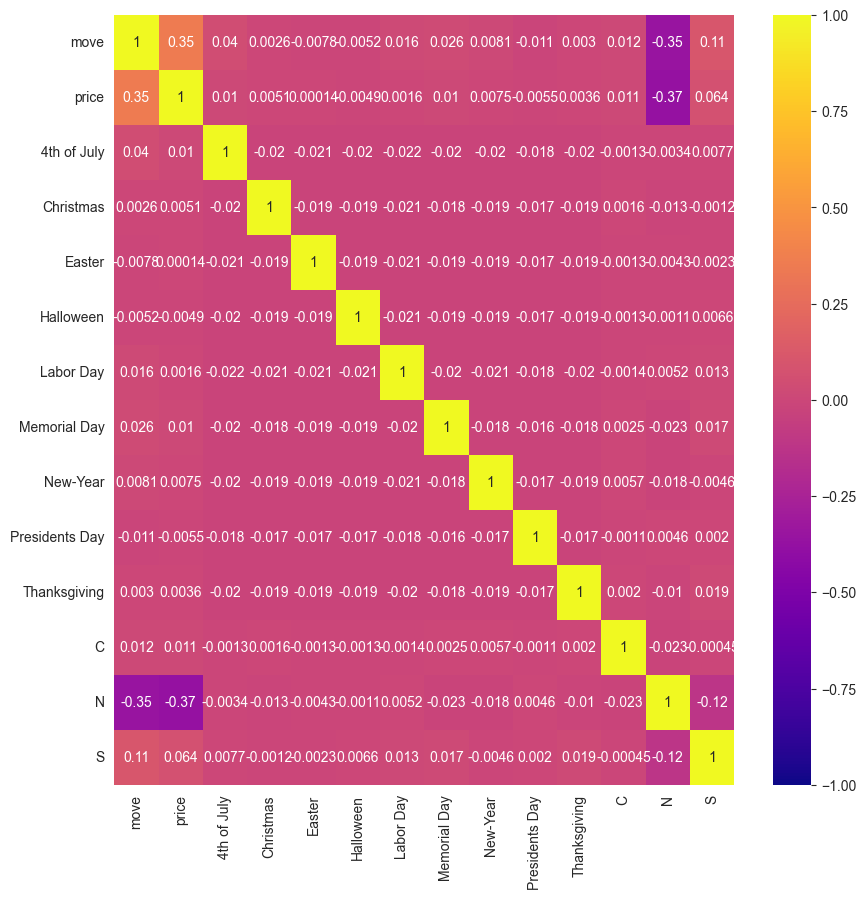

In [666]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_correlations(df, n=5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(key=abs, ascending=False)
    return au_corr[0:n]


print(get_top_correlations(beer_sales_data_ohe.select_dtypes(['number', 'bool']), 10))

plt.figure(figsize=(10, 10))
sns.heatmap(beer_sales_data_ohe.select_dtypes(['number', 'bool']).corr(), annot=True, vmin=-1, vmax=1, cmap='plasma')

del beer_sales_data_ohe

В силу того, что максимальная корреляция небольшая, не будем удалять никаких столбцов.

### Работа с категориальными признаками

In [667]:
beer_sales_data.describe(include='object')

,store,upc,week,sale
count,3967720,3967720,3967720,3967720
unique,89,788,302,4
top,126,8066095605,317,N
freq,74757,21558,18517,3420284


Посмотрим на распределение **sale**

In [668]:
beer_sales_data['sale'].value_counts()

sale
N    3420284
B     537358
S       9745
C        333
Name: count, dtype: int64

### Изучение

Посмотрим на распределение **price** от **sale**

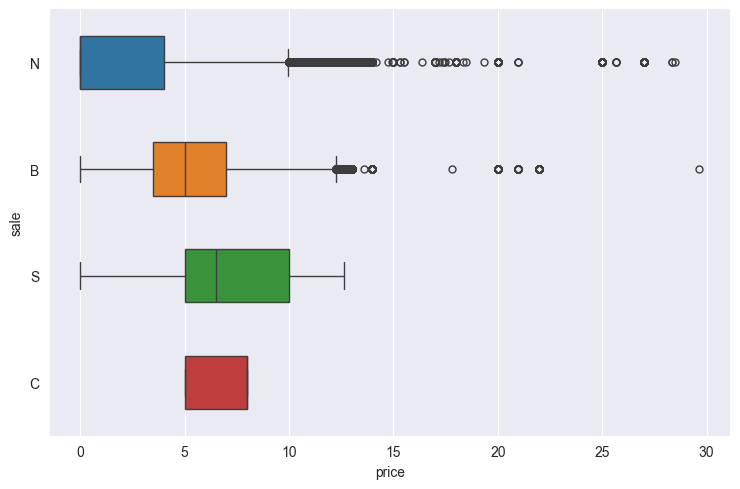

In [669]:
sns.catplot(data=beer_sales_data, x="price", y="sale", hue="sale", kind="box", height=5, aspect=1.5, width=0.5)

Посмотрим на распределение **move** от **sale**

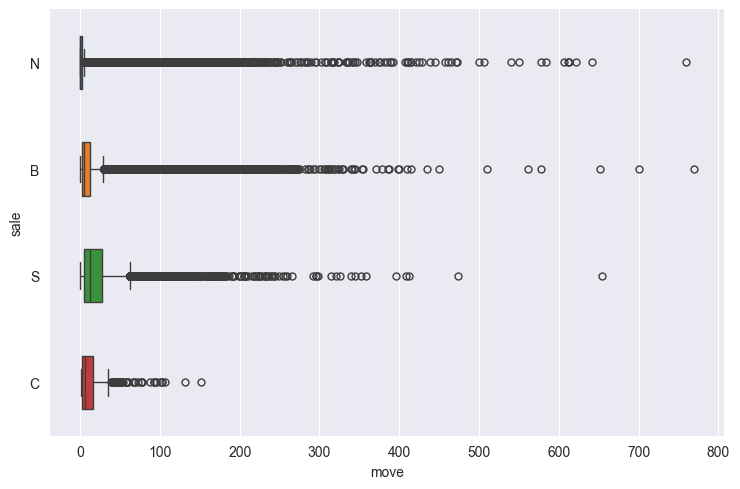

In [670]:
sns.catplot(data=beer_sales_data, x="move", y="sale", hue="sale", kind="box", height=5, aspect=1.5, width=0.5)

Можно заметить, что на обоих графиках видно достаточно большое количество выбросов. Пока оставим их #TODO 

In [671]:
beer_sales_data = pd.concat([beer_sales_data.drop(columns=['sale']),
                             pd.get_dummies(beer_sales_data['sale'], drop_first=True)], axis=1)
beer_sales_data.head()

,store,upc,week,move,price,4th of July,Christmas,Easter,Halloween,Labor Day,Memorial Day,New-Year,Presidents Day,Thanksgiving,C,N,S
0,2,294,298,11,2.62,False,False,False,False,False,True,False,False,False,False,True,False
1,2,294,299,9,2.51,False,False,False,False,False,False,False,False,False,False,True,False
2,2,294,300,6,2.49,False,False,False,False,False,False,False,False,False,False,True,False
3,2,294,301,5,2.99,False,False,False,False,False,False,False,False,False,False,True,False
4,2,294,302,1,2.49,False,False,False,False,False,False,False,False,False,False,True,False


Посмотрим на распределение количества продаж магазинов по неделям

In [672]:
beer_sales_data['store'].value_counts()

store
126    74757
134    72598
100    72475
101    72284
129    72034
       ...  
48        78
47        78
28        78
92        74
44        74
Name: count, Length: 89, dtype: int64

<Axes: xlabel='week', ylabel='move'>

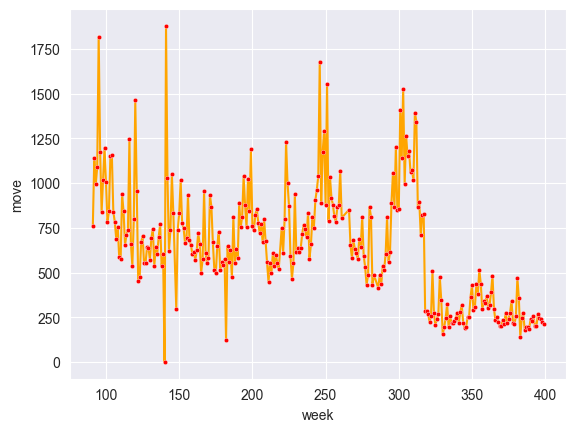

In [673]:
store_id = 74
sns.lineplot(
    data=beer_sales_data[beer_sales_data['store'] == store_id][['week', 'move']].groupby('week').agg({'move': 'sum'}),
    x='week',
    y='move',
    c='orange',
    zorder=1)

sns.scatterplot(
    data=beer_sales_data[beer_sales_data['store'] == store_id][['week', 'move']].groupby('week').agg({'move': 'sum'}),
    x='week',
    y='move',
    color='red',
    zorder=3,
    s=10)

Найдёт топ 10 лучших и худших магазинов по сумме продаже за всё время

In [674]:
beer_sales_revenue

,store,upc,week,move,price,sale,event,revenue
0,2,294,298,11,2.62,N,Memorial Day,28.82
1,2,294,299,9,2.51,N,NaN,22.59
2,2,294,300,6,2.49,N,NaN,14.94
3,2,294,301,5,2.99,N,NaN,14.95
4,2,294,302,1,2.49,N,NaN,2.49
...,...,...,...,...,...,...,...,...
3990667,136,79709638102,395,0,0.00,N,NaN,0.00
3990668,136,79709638102,396,0,0.00,N,NaN,0.00
3990669,136,79709638102,397,0,0.00,N,NaN,0.00
3990670,136,79709638102,398,0,0.00,N,NaN,0.00


In [675]:
beer_sales_shops_sales_amount = beer_sales_data.groupby('store').agg(
    total_sales=('price', 'sum')
).reset_index()

beer_sales_shops_sales_revenue = beer_sales_revenue.groupby('store').agg(
    total_revenue=('revenue', 'sum')
).reset_index()

beer_shops_top_10_sales_amount = beer_sales_shops_sales_amount.nlargest(10, 'total_sales')
beer_shops_top_10_sales_revenue = beer_sales_shops_sales_revenue.nlargest(10, 'total_revenue')

beer_shops_worst_10_sales_amount = beer_sales_shops_sales_amount.nsmallest(10, 'total_sales')
beer_shops_worst_10_sales_revenue = beer_sales_shops_sales_revenue.nsmallest(10, 'total_revenue')

<Axes: title={'center': 'Топ 10 по количеству продаж'}, xlabel='total_sales', ylabel='store'>

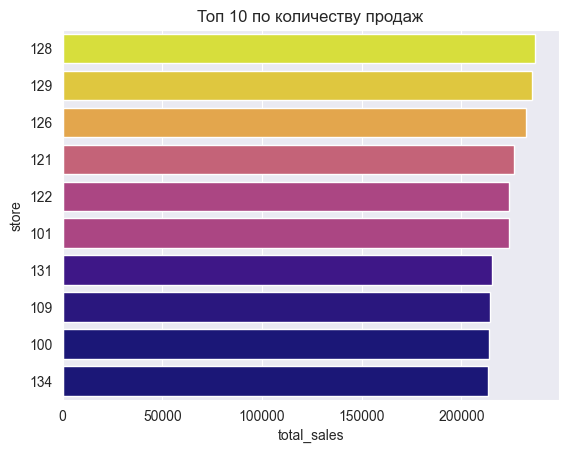

In [676]:
plt.title('Топ 10 по количеству продаж')
sns.barplot(data=beer_shops_top_10_sales_amount, y='store', hue='total_sales', x='total_sales',
            orient='h', legend=False, order=beer_shops_top_10_sales_amount['store'], palette='plasma')

<Axes: title={'center': 'Топ 10 по сумме продаж'}, xlabel='total_revenue', ylabel='store'>

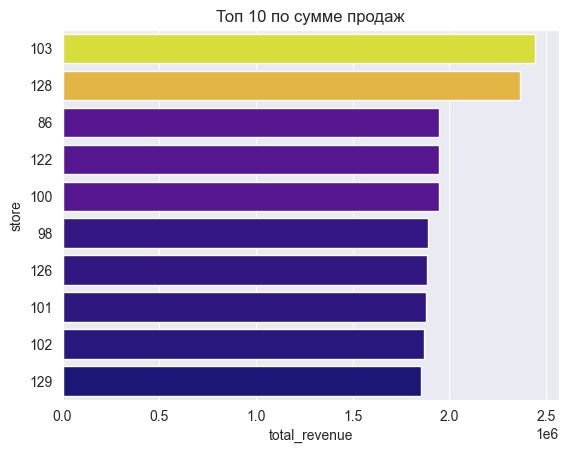

In [677]:
plt.title('Топ 10 по сумме продаж')
sns.barplot(data=beer_shops_top_10_sales_revenue, y='store', hue='total_revenue', x='total_revenue',
            orient='h', legend=False, order=beer_shops_top_10_sales_revenue['store'], palette='plasma')

,store,total_sales
44,92,2.49
13,47,4.99
14,48,9.78
8,28,12.57
12,44,15.32
37,83,17.16
0,2,34.64
40,88,9859.76
88,146,13879.68
85,142,17098.22


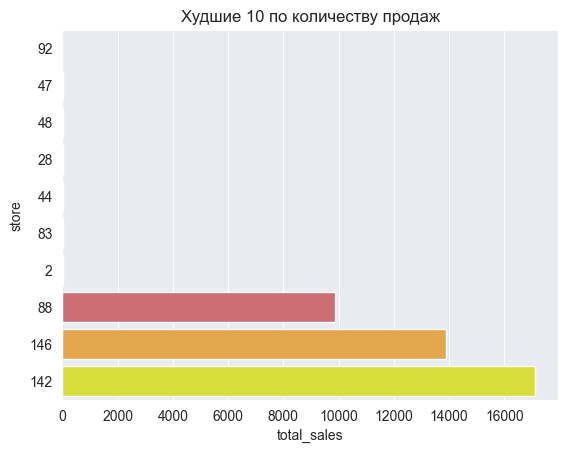

In [678]:
plt.title('Худшие 10 по количеству продаж')
sns.barplot(data=beer_shops_worst_10_sales_amount, y='store', hue='total_sales', x='total_sales',
            orient='h', legend=False, order=beer_shops_worst_10_sales_amount['store'], palette='plasma')
beer_shops_worst_10_sales_amount

<Axes: title={'center': 'Худшие 10 по сумме продаж'}, xlabel='total_revenue', ylabel='store'>

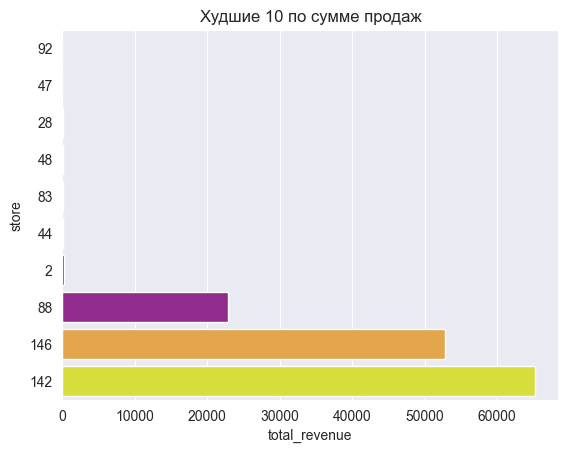

In [679]:
plt.title('Худшие 10 по сумме продаж')
sns.barplot(data=beer_shops_worst_10_sales_revenue, y='store', hue='total_revenue', x='total_revenue',
            orient='h', legend=False, order=beer_shops_worst_10_sales_revenue['store'], palette='plasma')

In [680]:
beer_sales_shops_sales_revenue['total_revenue'].describe()

count    8.900000e+01
mean     8.953608e+05
std      6.221066e+05
min      2.490000e+00
25%      4.178397e+05
50%      8.146373e+05
75%      1.256403e+06
max      2.441568e+06
Name: total_revenue, dtype: float64

In [681]:
del beer_sales_shops_sales_amount
del beer_sales_shops_sales_revenue
del beer_shops_top_10_sales_amount
del beer_shops_top_10_sales_revenue
del beer_shops_worst_10_sales_amount
del beer_shops_worst_10_sales_revenue

## EDA beer_upc

In [213]:
upc_cols2drop = ['com_code', 'case']
beer_upc_data = pd.read_parquet('Data/beer_upc.parquet').drop(columns=upc_cols2drop)

In [214]:
beer_upc_data.head()

,upc,descrip,size,nitem
0,294,BEER LIMIT,12/12O,9990180
1,307,HEINEKEN KINGSIZE CA,259 OZ,9490410
2,710,BUDWEISER BEER,24/12O,9402300
3,711,BUDWEISER DRY BEER,24/12O,9402650
4,712,BUDWEISER LIGHT BEER,24/12O,9402600


Аналогично beer_sales меняем колонку **upc** на **object**

In [215]:
beer_upc_data = beer_upc_data.astype({'upc': 'object'})

Удаляем столбцы **nitem** и **size** в силу отсутствия явной важности

In [222]:
beer_upc_data.drop(columns=['nitem', 'size'], inplace=True)

In [224]:
beer_upc_data.describe()

,upc,descrip
count,790,790
unique,790,514
top,294,OLD STYLE CLASSIC DR
freq,1,16


Будем делать эмбединг для колонки **descrip**.  
Попробуем использовать **BERT** + **PCA**

In [286]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return embedding

In [281]:
z = get_embedding(beer_upc_data.descrip.to_list())

In [288]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25)
res = pd.DataFrame(pca.fit_transform(z))
pca.explained_variance_ratio_.sum()

0.67373765

In [290]:
beer_upc_data = pd.concat([beer_upc_data.drop(columns=['descrip']), res], axis=1)
beer_upc_data.head()

,upc,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,294,-0.958943,-1.498041,-0.002954,0.639329,0.268534,-0.137883,-0.570137,-0.042107,-0.167466,...,0.163028,-1.245292,0.094917,0.303394,0.205467,0.266631,0.679468,0.418837,0.060436,-0.321797
1,307,-0.125261,1.262521,0.769475,-0.470601,-0.896736,0.530484,-0.246771,1.555093,-0.086164,...,0.064302,0.756391,-0.451863,0.485849,0.228847,-0.063100,0.427384,-0.180133,-0.489792,0.681920
2,710,4.629253,-2.737576,-1.622777,-0.201910,-0.133220,0.114603,-0.194335,0.133224,-0.187140,...,0.290708,-0.598506,-0.418198,-0.735827,0.436811,-0.284175,0.103616,-0.096969,-0.558766,0.368039
3,711,4.327162,-3.113009,-0.909289,0.030502,-0.541001,-0.252763,-1.046683,-0.735276,0.289203,...,0.431946,-0.425944,-0.259976,-0.273556,0.370996,-0.380964,-0.554178,0.185280,-0.571791,0.295823
4,712,4.476841,-3.185945,-1.171386,0.488479,-0.082007,-0.200540,-1.217949,-0.503848,-0.017919,...,0.285597,-0.201582,-0.509913,-0.156342,0.383368,-0.502659,-0.824557,0.207966,-0.565204,0.454860


Видно, что при достаточно небольшом `n_components` удалось сохранить почти 70% изначальной дисперсии.

## EDA demographic_data

In [228]:
demographic_data = pd.read_parquet('Data/demographic_data.parquet')

In [291]:
demographic_data

,store,age60,age9,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
1,2.0,0.232865,0.117509,0.248935,0.114280,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.927280,0.376927
2,4.0,0.262030,0.095090,0.220789,0.062161,10.646972,0.088123,0.362122,0.522236,2.373200,1.000000,1.104470,0.772489
3,5.0,0.117368,0.141433,0.321226,0.053875,10.922371,0.103092,0.410568,0.535883,3.801998,0.681818,1.600573,0.736307
4,8.0,0.252394,0.123155,0.095173,0.035243,10.597010,0.131750,0.283075,0.054227,2.636333,1.500000,2.905384,0.641016
5,9.0,0.269119,0.103503,0.222172,0.032619,10.787151,0.096830,0.358995,0.505747,1.103279,0.666667,1.820474,0.441268
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,308.0,0.235498,0.120519,0.159787,0.185974,10.439542,0.113268,0.316430,0.290223,NaN,NaN,NaN,NaN
104,309.0,0.067192,0.200156,0.278103,0.204785,10.757754,0.152418,0.392109,0.406664,NaN,NaN,NaN,NaN
105,310.0,0.177015,0.134641,0.283289,0.045067,10.861496,0.100310,0.421429,0.594775,NaN,NaN,NaN,NaN
106,312.0,0.161864,0.151115,0.122721,0.195317,10.500509,0.139724,0.309058,0.096444,NaN,NaN,NaN,NaN


## Построение моделей

In [302]:
beer_full_data = (beer_sales_data
                  .join(beer_upc_data.set_index('upc'), how='inner', on='upc')
                  .join(demographic_data.set_index('store'), how='inner', on='store')).sort_values('week',
                                                                                                   ascending=True)
beer_full_data.set_index(['store', 'week', 'upc'], inplace=True, drop=True)
beer_full_data.head()

,,,move,price,4th of July,Christmas,Easter,Halloween,Labor Day,Memorial Day,New-Year,Presidents Day,...,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
store,week,upc,,,,,,,,,,,,,,,,,,,,,
33,91,7204000009,4,3.49,False,False,False,False,False,False,False,False,...,0.419688,0.130127,10.345927,0.013506,0.472308,0.862559,3.129556,2.416667,0.867215,0.752825
56,91,3410017306,13,11.99,False,False,False,False,False,False,False,False,...,0.237551,0.041356,10.831825,0.105928,0.362168,0.578125,4.865721,0.533333,2.998578,0.496127
128,91,7336011421,0,0.00,False,False,False,False,False,False,False,False,...,0.211897,0.355911,10.153429,0.100043,0.398251,0.266187,10.667447,2.000000,1.409464,0.259004
129,91,7336068741,0,0.00,False,False,False,False,False,False,False,False,...,0.307843,0.034129,10.999864,0.122081,0.367876,0.691440,7.082315,1.041667,2.656879,0.342211
126,91,7204001122,3,3.69,False,False,False,False,False,False,False,False,...,0.413222,0.045019,10.980876,0.113699,0.421959,0.573626,5.065201,1.690476,1.858260,0.717799


### Catboost

In [307]:
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

ts_split = TimeSeriesSplit(n_splits=10)
X = beer_full_data.drop(columns=['move'])
y = beer_full_data['move']

mse_scores = []
for train_index, test_index in ts_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostRegressor()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

print(f'Mean Squared Error for each split: {mse_scores}')
print(f'Average MSE: {np.mean(mse_scores)}')

Learning rate set to 0.103594
0:	learn: 11.1851756	total: 54ms	remaining: 54s
1:	learn: 10.8695874	total: 83.9ms	remaining: 41.9s
2:	learn: 10.6096326	total: 113ms	remaining: 37.5s
3:	learn: 10.4158582	total: 148ms	remaining: 37s
4:	learn: 10.2427503	total: 184ms	remaining: 36.6s
5:	learn: 10.0872309	total: 215ms	remaining: 35.6s
6:	learn: 9.9419811	total: 247ms	remaining: 35s
7:	learn: 9.7262376	total: 281ms	remaining: 34.8s
8:	learn: 9.5460675	total: 314ms	remaining: 34.5s
9:	learn: 9.4505764	total: 347ms	remaining: 34.3s
10:	learn: 9.3445983	total: 377ms	remaining: 33.9s
11:	learn: 9.2053391	total: 409ms	remaining: 33.7s
12:	learn: 9.1081366	total: 437ms	remaining: 33.2s
13:	learn: 8.9995358	total: 470ms	remaining: 33.1s
14:	learn: 8.8925318	total: 496ms	remaining: 32.5s
15:	learn: 8.8380851	total: 527ms	remaining: 32.4s
16:	learn: 8.7729499	total: 553ms	remaining: 32s
17:	learn: 8.6810200	total: 582ms	remaining: 31.7s
18:	learn: 8.6118061	total: 607ms	remaining: 31.4s
19:	learn: 8.

In [1084]:
X_test

,,,price,4th of July,Christmas,Easter,Halloween,Labor Day,Memorial Day,New-Year,Presidents Day,Thanksgiving,...,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
store,week,upc,,,,,,,,,,,,,,,,,,,,,
132,359,8382012455,0.00,False,False,False,False,False,False,False,False,False,...,0.264528,0.273974,10.619154,0.129984,0.352755,0.148871,2.312046,1.562500,2.795615,0.478340
33,359,6821309112,0.00,False,False,False,False,False,False,False,False,False,...,0.419688,0.130127,10.345927,0.013506,0.472308,0.862559,3.129556,2.416667,0.867215,0.752825
121,359,8382023471,0.00,False,False,False,False,False,False,False,False,False,...,0.350613,0.039174,10.949929,0.091694,0.382304,0.610862,3.751225,1.090909,2.069346,0.559534
139,359,1820000670,0.00,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,359,8066095603,2.19,False,False,False,False,False,False,False,False,False,...,0.095173,0.035243,10.597010,0.131750,0.283075,0.054227,2.636333,1.500000,2.905384,0.641016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,399,79709635767,5.49,False,False,False,False,False,False,False,False,False,...,0.171917,0.025426,10.620839,0.130341,0.313190,0.316889,2.102554,1.250000,2.226766,0.310203
129,399,8549873401,0.00,False,False,False,False,False,False,False,False,False,...,0.307843,0.034129,10.999864,0.122081,0.367876,0.691440,7.082315,1.041667,2.656879,0.342211
139,399,6821302112,5.99,False,False,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1085]:
model

ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
for i, (event, weeks) in enumerate(beer_sales_revenue_event_weeks.items()):
    sns.lineplot(data=beer_sales_revenue_by_week,
                 x='week',
                 y='revenue',
                 c='orange',
                 zorder=1)

### ARIMA

Проверим ряд на стационарность

In [965]:
beer_full_data.head()

,,,move,price,4th of July,Christmas,Easter,Halloween,Labor Day,Memorial Day,New-Year,Presidents Day,...,educ,ethnic,income,hhlarge,workwom,hval150,sstrdist,sstrvol,cpdist5,cpwvol5
store,week,upc,,,,,,,,,,,,,,,,,,,,,
33,91,7204000009,4,3.49,False,False,False,False,False,False,False,False,...,0.419688,0.130127,10.345927,0.013506,0.472308,0.862559,3.129556,2.416667,0.867215,0.752825
56,91,3410017306,13,11.99,False,False,False,False,False,False,False,False,...,0.237551,0.041356,10.831825,0.105928,0.362168,0.578125,4.865721,0.533333,2.998578,0.496127
128,91,7336011421,0,0.00,False,False,False,False,False,False,False,False,...,0.211897,0.355911,10.153429,0.100043,0.398251,0.266187,10.667447,2.000000,1.409464,0.259004
129,91,7336068741,0,0.00,False,False,False,False,False,False,False,False,...,0.307843,0.034129,10.999864,0.122081,0.367876,0.691440,7.082315,1.041667,2.656879,0.342211
126,91,7204001122,3,3.69,False,False,False,False,False,False,False,False,...,0.413222,0.045019,10.980876,0.113699,0.421959,0.573626,5.065201,1.690476,1.858260,0.717799


#### По категории

In [967]:
beer_full_sales_amount_by_week = beer_full_data.groupby('week').agg(
    sales_amount=pd.NamedAgg('move', 'sum')).reset_index().sort_values(by='week')
beer_full_sales_amount_by_week.head()

,week,sales_amount
0,91,58515
1,92,70570
2,93,69579
3,94,70108
4,95,100298


<Axes: title={'center': 'beer_sales_amount_by_week'}, xlabel='week', ylabel='sales_amount'>

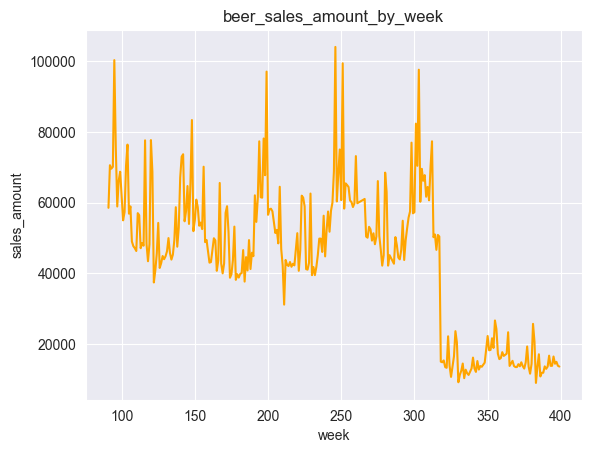

In [968]:
plt.title('beer_sales_amount_by_week')
sns.lineplot(x=beer_full_sales_amount_by_week['week'],
             y=beer_full_sales_amount_by_week['sales_amount'],
             c='orange',
             zorder=1)

Проверим данные на стационарность

In [973]:
from statsmodels.tsa.stattools import adfuller

print(f'p-value: {adfuller(beer_full_sales_amount_by_week["sales_amount"])[1]}')

p-value: 0.41174174195412927


В силу того, что p-value > 0.05, отвергаем гипотезу о том, что ряд стационарен.

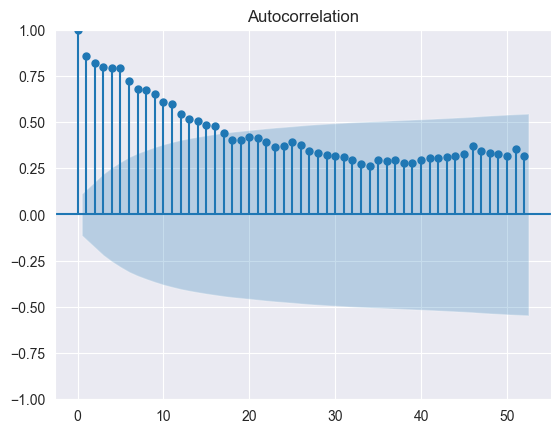

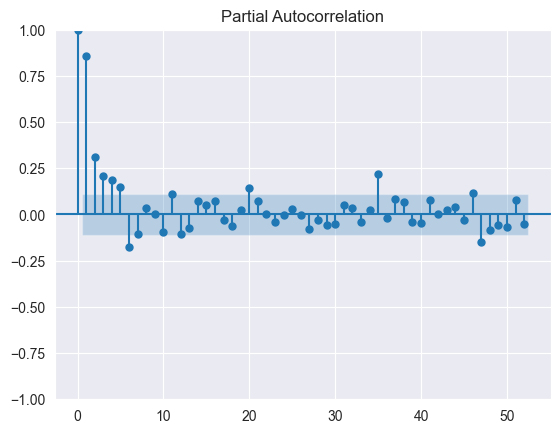

In [975]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(beer_full_sales_amount_by_week['sales_amount'], lags=52)
pacf = plot_pacf(beer_full_sales_amount_by_week['sales_amount'], lags=52)

В силу того, что на 52 шаге (1 год), значения на обоих графиках лежат в пределах 95% доверительного интервала, то мы не можем принять гипотезу о том, что в данных есть явная сезонность

Применим дифференцирование на 1, чтобы привести среднее к константе

<Axes: title={'center': 'beer_sales_amount_by_week'}, xlabel='week', ylabel='sales_amount'>

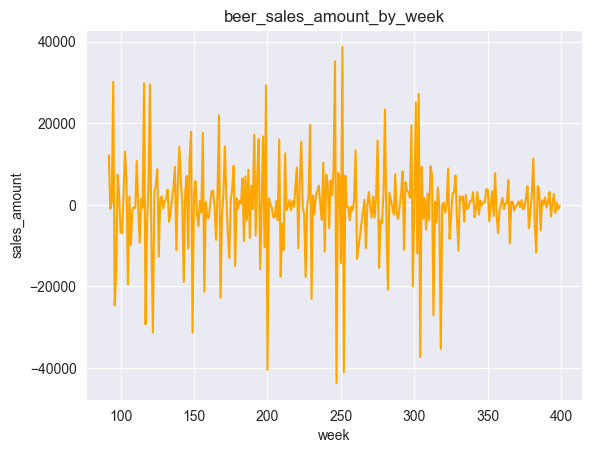

In [1052]:
plt.title('beer_sales_amount_by_week')
sns.lineplot(x=beer_full_sales_amount_by_week['week'],
             y=beer_full_sales_amount_by_week['sales_amount'].diff(1),
             c='orange',
             zorder=1)

Проверим данные на стационарность

In [1072]:
from statsmodels.tsa.stattools import adfuller

print(f'p-value: {adfuller(beer_full_sales_amount_by_week["sales_amount"].diff(1).dropna())[1]}')

p-value: 2.944384681798226e-07


В силу того, что p-value < 0.05, принимаем гипотезу о том, что ряд стационарен.

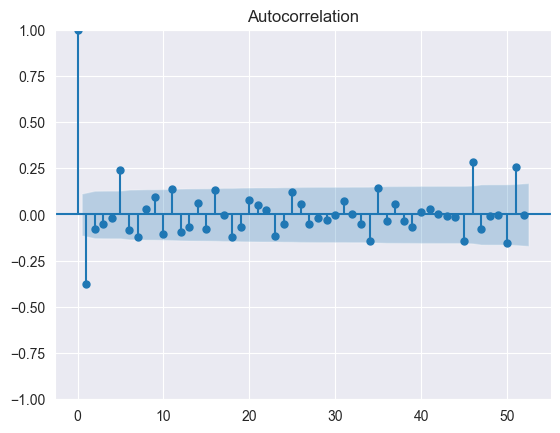

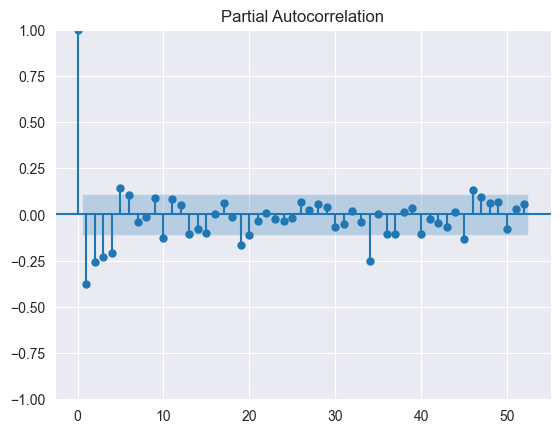

In [1073]:
acf_diff = plot_acf(beer_full_sales_amount_by_week['sales_amount'].diff(1).dropna(), lags=52)
pacf_diff = plot_pacf(beer_full_sales_amount_by_week['sales_amount'].diff(1).dropna(), lags=52)

Явной сезонности не видно

Применим **auto_arima**

In [1079]:
from pmdarima.arima import auto_arima

model = auto_arima(beer_full_sales_amount_by_week.sort_values('week')['sales_amount'].diff(1).dropna(),
                   test='adf',
                   start_p=1,
                   max_p=52,
                   start_q=1,
                   max_q=52,
                   d=1,
                   max_d=52,
                   error_action='ignore',
                   supress_warnings=True,
                   trace=True,
                   stationary=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6379.832, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6456.005, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6411.682, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6377.811, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6454.062, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6380.245, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6378.502, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6375.761, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6377.288, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6376.928, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6409.823, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6376.958, Time=1.28 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 4.168 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  301
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3185.880
Date:                Sun, 15 Dec 2024   AIC                           6375.761
Time:                        14:02:57   BIC                           6383.175
Sample:                             0   HQIC                          6378.728
                                - 301                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5863      0.033    -17.884      0.000      -0.651      -0.522
sigma2      8.948e+07   8.37e-12   1.07e+19      0.000    8.95e+07    8.95e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               135.16
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.14e+34. Standard errors may be unstable.
"""

<Axes: xlabel='week', ylabel='sales_amount'>

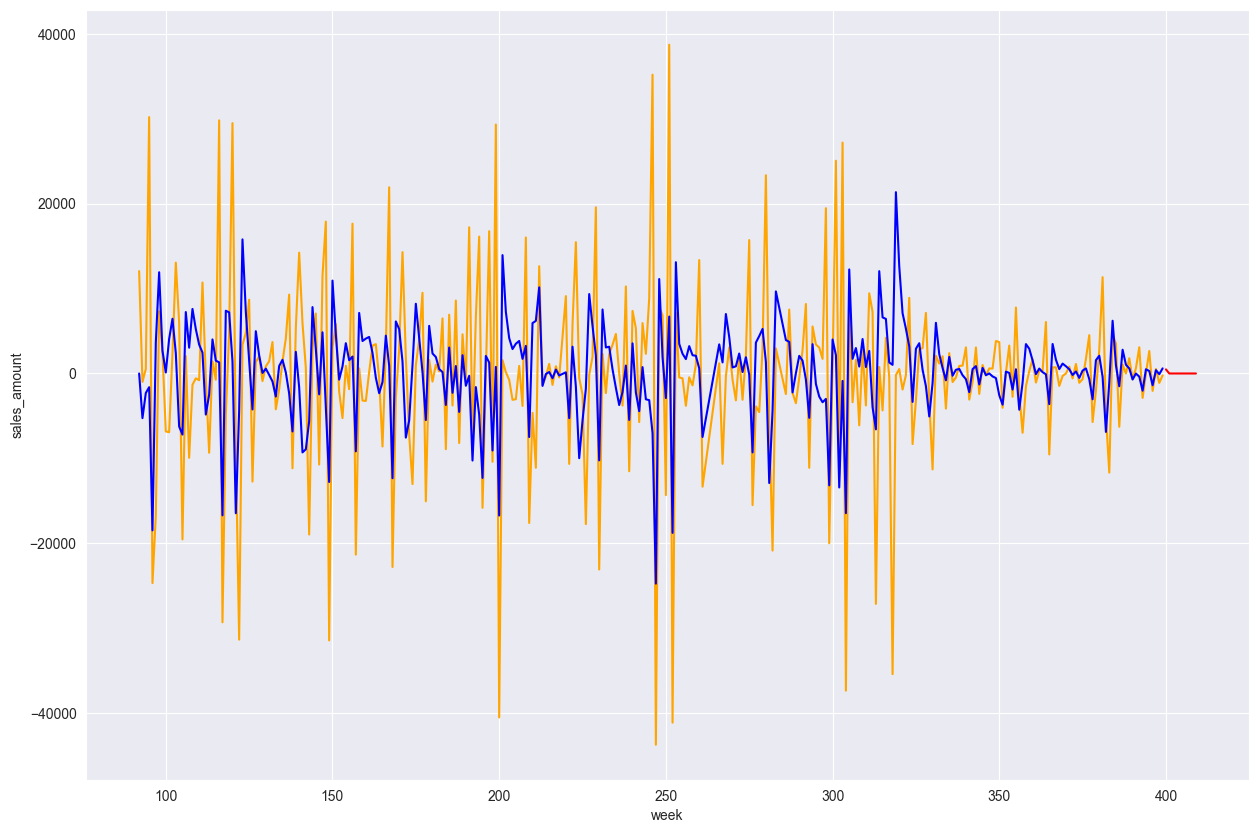

In [1080]:
import warnings

warnings.filterwarnings('ignore')

n_periods = 10
in_sample_preds = model.predict_in_sample()
future_preds = model.predict(n_periods=n_periods)

plt.figure(figsize=(15, 10))
sns.lineplot(x=beer_full_sales_amount_by_week.sort_values('week')['week'],
             y=beer_full_sales_amount_by_week.sort_values('week')['sales_amount'].diff(1),
             c='orange',
             zorder=1)

sns.lineplot(x=beer_full_sales_amount_by_week.sort_values('week').iloc[in_sample_preds.index]['week'],
             y=in_sample_preds,
             c='blue',
             zorder=2)

sns.lineplot(
    x=range(beer_full_sales_amount_by_week['week'].max() + 1,
            beer_full_sales_amount_by_week['week'].max() + 1 + n_periods),
    y=future_preds,
    c='red',
    zorder=3)

In [1082]:
from sklearn.metrics import mean_squared_error

mean_squared_error(in_sample_preds, beer_full_sales_amount_by_week.sort_values('week')['sales_amount'].diff(1)[1:])

91417227.69536243

Судя по графику, arima с автоматическим подбором параметров справилась не очень :(

### ARIMAX